### - взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
#test = pd.read_csv('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/ml_buisness/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/ml_buisness/test.csv")
print(df.shape)
df.head(3)

(7500, 17)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


### - сделать обзорный анализ выбранного датасета

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df.shape

(7500, 17)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [26]:
# Анализ целевой переменной
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [27]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [28]:
# Убираем лишние 0 в Credit Score  в train
for cr_score in df['Credit Score']:
    if (len(str(cr_score))) > 5:
        # print(cr_score)
        df.loc[df['Credit Score'] == cr_score, 'Credit Score'] = cr_score/10

In [29]:
# Убираем лишние 0 в Credit Score в test
for cr_score in df_test['Credit Score']:
    if (len(str(cr_score))) > 5:
        # print(cr_score)
        df_test.loc[df_test['Credit Score'] == cr_score, 'Credit Score'] = cr_score/10

In [30]:
df = df[df['Maximum Open Credit']<99999999]
df_test = df_test[df_test['Maximum Open Credit']<99999999]

In [31]:
median_loan_by_purpose = df.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'})
median_loan_by_purpose_test = df_test.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'})

In [32]:
for purpose in median_loan_by_purpose['Purpose']:
    df.loc[(df['Current Loan Amount']==99999999) & (df['Purpose']==str(purpose)), 'Current Loan Amount'] = median_loan_by_purpose.loc[median_loan_by_purpose['Purpose']==purpose, 'Current Loan Amount']

for purpose in median_loan_by_purpose_test['Purpose']:
    df_test.loc[(df_test['Current Loan Amount']==99999999) & (df_test['Purpose']==str(purpose)), 'Current Loan Amount'] = median_loan_by_purpose_test.loc[median_loan_by_purpose_test['Purpose']==purpose, 'Current Loan Amount']

##### Обработка пропусков

In [33]:
median_annual_income = df['Annual Income'].median()
df['Annual Income'] = df['Annual Income'].fillna(median_annual_income)


In [34]:
median_annual_income = df_test['Annual Income'].median()
df_test['Annual Income'] = df_test['Annual Income'].fillna(median_annual_income)


In [35]:
median_cred_score = df['Credit Score'].median()
df['Credit Score'] = df['Credit Score'].fillna(median_cred_score)


In [36]:
median_cred_score = df_test['Credit Score'].median()
df_test['Credit Score'] = df_test['Credit Score'].fillna(median_cred_score)

In [37]:
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
df_test['Bankruptcies'] = df_test['Bankruptcies'].fillna(0)

In [38]:
df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode()[0]
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = df_test['Years in current job'].mode()[0]

In [39]:
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)
df_test['Months since last delinquent'] = df_test['Months since last delinquent'].fillna(0)


In [40]:
# Сохраним подготовленные данные
df_train_prep= df.copy()
df_test_prep=df_test.copy()

##### Обучение модели

In [41]:
# Целевой признак
target = 'Credit Default'
# Все признаки 
features_all = df_train_prep.columns.drop('Credit Default').tolist()
# Num
features_without_categ =['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History','Maximum Open Credit', 'Number of Credit Problems','Bankruptcies', 'Current Loan Amount', 'Current Credit Balance','Monthly Debt','Credit Score']
features_categ=['Home Ownership','Years in current job','Purpose','Term']

In [42]:
for colname in features_categ:
    df_train_prep[colname] = pd.Categorical(df_train_prep[colname])
    
df_train_prep[features_categ].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [43]:
for colname in features_categ:
    df_test_prep[colname] = pd.Categorical(df_test_prep[colname])
    
df_test_prep[features_categ].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

In [44]:
# Создаем датафреймы из данных
X=pd.DataFrame(df_train_prep, columns=features_without_categ)
X.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,1.0,NaN,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,0.0,NaN,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,0.0,125840.0,93309.0,7180.0,719.0


In [45]:
y = df_train_prep['Credit Default']

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True,stratify=df_train_prep['Credit Default'], random_state=2)
X_train.shape, X_test.shape

((5997, 11), (1500, 11))

In [47]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [48]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

0    4307
1    3380
Name: Credit Default, dtype: int64

In [49]:
X_train = df_balanced.drop(columns=target)
y_train = df_balanced[target]

In [51]:
pip install catboost

     |████████████████████████████████| 67.4 MB 28 kB/s 


In [53]:
import catboost as cb
cb_params = {
    "n_estimators": 2000,
    "loss_function": "Logloss",
    "eval_metric": "F1",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 3,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42,
    #"cat_features": features_categ,
    #"reg_lambda":0.5,
    #'class_weights':[1, disbalance]
    
}

### - обучить любой классификатор (какой вам нравится)

In [54]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

0:	learn: 0.5702006	test: 0.5702006	test1: 0.4495413	best: 0.4495413 (0)	total: 64.8ms	remaining: 2m 9s
10:	learn: 0.5984533	test: 0.5984533	test1: 0.4465021	best: 0.4544524 (5)	total: 117ms	remaining: 21.1s
20:	learn: 0.6016381	test: 0.6016381	test1: 0.4585062	best: 0.4615385 (16)	total: 187ms	remaining: 17.6s
30:	learn: 0.5943482	test: 0.5943482	test1: 0.4377682	best: 0.4615385 (16)	total: 236ms	remaining: 15s
40:	learn: 0.6039903	test: 0.6039903	test1: 0.4439701	best: 0.4615385 (16)	total: 290ms	remaining: 13.9s
50:	learn: 0.6045662	test: 0.6045662	test1: 0.4456290	best: 0.4615385 (16)	total: 343ms	remaining: 13.1s
60:	learn: 0.6102728	test: 0.6102728	test1: 0.4532760	best: 0.4615385 (16)	total: 394ms	remaining: 12.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4615384615
bestIteration = 16

Shrink model to first 17 iterations.


 ### - разобраться с SHAP и построить важности признаков для:

##### a. - всего тестового набора данных (summary_plot - дать интерпретацию)

In [56]:
pip install shap

     |████████████████████████████████| 356 kB 5.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491664 sha256=ff4d3591ed38a9bfd07dd8fbdb573e5fd78a6a60a4ab815c8cc8eaa64bc7a115
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [57]:
import shap

In [60]:
!initjs()

/bin/bash: -c: line 1: syntax error: unexpected end of file


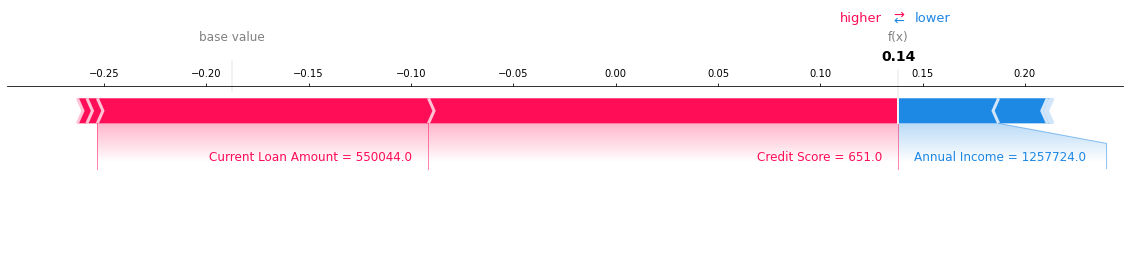

In [61]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

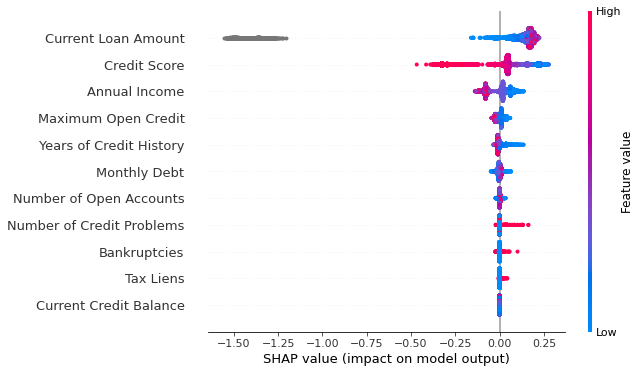

In [62]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Наибольшее влияние оказывают признаки: Current Loan Amount, Credit Score, Annual Income.
